In [1]:
import os
import h5py
import numpy as np
from astropy.io import fits
from astropy import table as aTable
from provabgs.util import readDESIspec

In [2]:
from provabgs import util as UT
from provabgs import infer as Infer
from provabgs import models as Models

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
dat_dir = '/global/homes/k/koposov/desi_koposov/m31_processing_scripts/reduction_2205/data/'

## read coadd, vrad, redrock files

In [5]:
coadd = readDESIspec(os.path.join(dat_dir, 'coadd_m31_all_220521.fits'))

In [6]:
zbest = aTable.Table.read(os.path.join(dat_dir, 'redrock_m31_all_220521.fits'))

In [7]:
vrad = aTable.Table.read(os.path.join('/global/cscratch1/sd/chahah/provabgs/m31/', 'All_clusters_M31.fits'))

In [8]:
rvtab = aTable.Table.read(os.path.join(dat_dir, 'rvtab_coadd_m31_all_220521.fits'))

In [9]:
targid = coadd["TARGETID"]

In [10]:
igals_coadd, igals_rvtab = [], []
for tid in vrad['TARGETID']: 
    assert np.sum(targid == tid) == 1
    igals_coadd.append(np.arange(len(targid))[targid == tid][0])
    
    assert np.sum(rvtab['TARGETID'] == tid) == 1
    igals_rvtab.append(np.arange(len(rvtab))[rvtab['TARGETID'] == tid][0])

(0, 15)

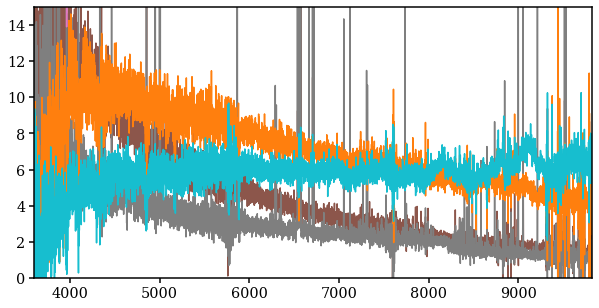

In [11]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for igal in igals_coadd[:5]: 
    sub.plot(coadd['wave_b'], coadd['flux_b'][igal], c='C%i' % igal)
    sub.plot(coadd['wave_r'], coadd['flux_r'][igal], c='C%i' % igal)
    sub.plot(coadd['wave_z'], coadd['flux_z'][igal], c='C%i' % igal)
sub.set_xlim(coadd['wave_b'].min(), coadd['wave_z'].max())
sub.set_ylim(0, 15)

## fit spectra using `provabgs`

In [12]:
# declare prior
priors = Infer.load_priors([
    Infer.UniformPrior(0., 10, label='sed'),
    Infer.FlatDirichletPrior(4, label='sed'), 
    Infer.UniformPrior(0., 1., label='sed'), 
    Infer.LogUniformPrior(1e-2, 13.27, label='sed'), 
    Infer.UniformPrior(np.array([6.9e-5, 6.9e-5, 0., 0., -2.2]),
                       np.array([7.3e-3, 7.3e-3, 3., 4., 0.4]), label='sed')
    ])

# declare model
m_nmf = Models.NMF(burst=True, emulator=True)

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [13]:
desi_mcmc = Infer.desiMCMC(
    model=m_nmf, 
    prior=priors
)

In [25]:
w1, f1 = m_nmf.sed(priors.transform(priors.sample()), -0.0016558242)
w2, f2 = m_nmf.sed(priors.transform(priors.sample()), -0.0016558242, tage=m_nmf.cosmo.age(0), d_lum=2.74e24)

TypeError: sed() got an unexpected keyword argument 'tage'

In [15]:
#for ii, igal in zip(range(7,8), igals_coadd[7:8]): 
ii = 0 
igal = igals_coadd[ii]

zred = vrad['VRAD'][ii] / 299792.458 
print(zred)

desi_mcmc = Infer.desiMCMC(
    model=m_nmf, 
    prior=priors)

mcmc = desi_mcmc.run(
    wave_obs=[coadd['wave_b'], coadd['wave_r'], coadd['wave_z']],
    flux_obs=[coadd['flux_b'][igal], coadd['flux_r'][igal], coadd['flux_z'][igal]],
    flux_ivar_obs=[coadd['ivar_b'][igal], coadd['ivar_r'][igal], coadd['ivar_z'][igal]],
    zred=zred, 
    tage=13.79,
    d_lum=2.35e24,
    sampler='zeus',
    nwalkers=30, 
    burnin=1000,
    opt_maxiter=10000,
    niter=1000, 
    debug=True)

-0.0016558242416324983
--- initializing the walkers ---


Initialising ensemble of 30 walkers...


initial theta = [3.5631942479425183, 0.9953347490991813, 0.8634327006294162, 0.4441161823987987, 0.437901550761328, 0.21525922391940133, 0.003953705064003818, 0.003254660752801902, 1.7826545966488183, 8.791917735862812e-07, -0.7654747370369785]
log Posterior(theta0) = -48690.613019
--- running MCMC ---


Sampling progress :   0%|          | 9/2000 [00:27<1:37:22,  2.93s/it]

KeyboardInterrupt: 

In [16]:
mcmc.keys()

dict_keys(['theta_bestfit', 'mcmc_chain', 'log_prob', 'redshift', 'wavelength_obs', 'flux_spec_obs', 'flux_ivar_spec_obs', 'flux_photo_obs', 'flux_ivar_photo_obs', 'flux_spec_model'])

(0.0, 15.0)

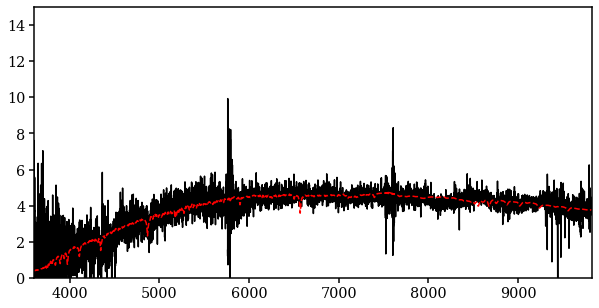

In [18]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(coadd.wave['b'], coadd.flux['b'][igal], c='k')
sub.plot(coadd.wave['r'], coadd.flux['r'][igal], c='k')
sub.plot(coadd.wave['z'], coadd.flux['z'][igal], c='k')

# plot best-fit
sub.plot(mcmc['wavelength_obs'], mcmc['flux_spec_model'], c='r', ls='--')

sub.set_xlim(coadd.wave['b'].min(), coadd.wave['z'].max())
sub.set_ylim(0, 15)